## 20133807 Jeong Seong Woon

### Import modules

In [1]:
from __future__ import print_function
import torch.nn as nn
import torch.nn.functional as F
import math
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision
import os
import numpy as np
import matplotlib.pyplot as plt
from pandas import Series, DataFrame
import pandas as pd
import torch.optim as optim
import torch.backends.cudnn as cudnn
import argparse
import sys
import time
import datetime 
import csv
import configparser
import platform
from torchvision import datasets, transforms
from torch.autograd import Variable
from random import shuffle

### Load Data using torchvision with mini-batch

In [13]:
transform = transforms.Compose([transforms.Grayscale(),transforms.ToTensor(),])
train_data_path = './horse-or-human/train'
trainset = torchvision.datasets.ImageFolder(root=train_data_path,\
                                            transform=transform)
loader_train = torch.utils.data.DataLoader(trainset, batch_size=30, \
                                           shuffle=True, num_workers=1)
test_data_path = './horse-or-human/validation'
testset = torchvision.datasets.ImageFolder(root=test_data_path, \
                                           transform=transform)
loader_test = torch.utils.data.DataLoader(testset, batch_size=30, \
                                          shuffle=True, num_workers=1)

### Class for nn model

In [14]:
class Linear(nn.Module):

    def __init__(self, num_classes=2):

        super(Linear, self).__init__()

        self.number_class   = num_classes

        _size_image     = 100* 100
        _num1           = 2000
        _num2           = 400
        _num3           = 200
        _num4           = 20
        _num5           = 10
        
        self.fc1        = nn.Linear(_size_image, _num1, bias=True)
        self.fc2        = nn.Linear(_num1, _num2, bias=True)
        self.fc3        = nn.Linear(_num2, _num3, bias=True)
        self.fc4        = nn.Linear(_num3, _num4, bias=True)
        self.fc5        = nn.Linear(_num4, _num5, bias=True)
        self.fc6        = nn.Linear(_num5, num_classes)

        self.fc_layer1  = nn.Sequential(self.fc1, nn.LeakyReLU(0.2, inplace=True))
        self.fc_layer2  = nn.Sequential(self.fc2, nn.LeakyReLU(0.2, inplace=True))
        self.fc_layer3  = nn.Sequential(self.fc3, nn.LeakyReLU(0.2, inplace=True))
        self.fc_layer4  = nn.Sequential(self.fc4, nn.ReLU(True))
        self.fc_layer5  = nn.Sequential(self.fc5, nn.ReLU(True))
        self.fc_layer6  = nn.Sequential(self.fc6, nn.Sigmoid()) #output Layer
        
        self.classifier = nn.Sequential(self.fc_layer1, self.fc_layer2,\
                                        self.fc_layer3, self.fc_layer4,\
                                        self.fc_layer5,self.fc_layer6)
        
        self._initialize_weight()        
        
    def _initialize_weight(self):        
            
        for m in self.modules():
            if isinstance(m, nn.Linear):
                n = m.in_features 
                m.weight.data.uniform_(- 1.0 / math.sqrt(n), 1.0 / math.sqrt(n))
                if m.bias is not None:
                    m.bias.data.zero_()

    def forward(self, x):

        x = x.view(x.size(0), -1)
        x = self.classifier(x)

        return x

### Generate Model

In [32]:
num_classes = 2
model = Linear(num_classes=num_classes)

### Generate optimizer and objective function

In [33]:
# ,weight_decay=1
optimizer   = optim.SGD(model.parameters(),lr = 0.1)
objective   = nn.CrossEntropyLoss()
init_lr = 0.05

### Function for adjusting Learning Rate at each Epoch

In [34]:
def adjust_lr(optimizer, epoch):
    lr = init_lr * (0.5 ** (epoch // 20))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

### Define train Function

In [35]:
def train():

    # print('train the model at given epoch')

    loss_train          = []
    accuracy_train = []
    correct =0

    model.train()

    for idx_batch, (data, target) in enumerate(loader_train):
#         print("batch",idx_batch)
#         if bCuda:
        
#             data, target    = data.cuda(), target.cuda()

        data, target    = Variable(data), Variable(target)

        optimizer.zero_grad()

        output  = model(data)
        loss    = objective(output, target)

        loss.backward()
        optimizer.step()

        loss_train_batch    = loss.item() / len(data)
#         loss_train_batch    = loss.item()
        loss_train.append(loss_train_batch)
        
        pred        = output.data.max(1)[1]
        correct     = pred.eq(target.data.view_as(pred)).cpu().sum()
        accuracy_train_batch   = 100. * float(correct) / len(target)
        accuracy_train.append(accuracy_train_batch) 
        
    loss_train_mean     = np.mean(loss_train) # 1 epoch 내의 모든 배치 loss의 평균
    accuracy_train_mean = np.mean(accuracy_train)#1 epoch 내의 모든 배치 accuracy의 평균
    loss_train_std      = np.std(loss_train)
    accuracy_train_std = np.std(accuracy_train)
    return {'loss_train_mean': loss_train_mean, \
            'accuracy_train_mean':accuracy_train_mean ,\
            'loss_train_std': loss_train_std, \
            'accuracy_train_std': accuracy_train_std}

### Define Test Function

In [36]:
def test():

    # print('test the model at given epoch')

    accuracy_test   = []
    loss_test       = 0
    correct         = 0

    model.eval()

    for idx_batch, (data, target) in enumerate(loader_test):


        data, target    = Variable(data), Variable(target)

        output  = model(data)
        loss    = objective(output, target)

        loss_test   += loss.item()
        pred        = output.data.max(1)[1]
        correct     += pred.eq(target.data.view_as(pred)).cpu().sum()

#     loss_test       = loss_test / len(loader_test.dataset)
    loss_test       = loss_test/len(loader_test.dataset)
    accuracy_test   = 100. * float(correct) / len(loader_test.dataset)
    return {'loss_test': loss_test, 'accuracy_test': accuracy_test}

### Run the model that generated

In [37]:
loss_train_mean =[]
loss_train_std = []
accuracy_train_mean =[]
accuracy_train_std = []
loss_test=[]
accuracy_test=[]
epoch_idx = 0
train_loss_old = 0
while(True):    
    adjust_lr(optimizer, epoch_idx) #adaptive learning_rate
    epoch_idx+=1
    result_train    = train()
    result_test     = test()
    train_loss_current = result_train['loss_train_mean']
    loss_train_mean.append(train_loss_current)
    loss_train_std.append(result_train['loss_train_std'])
    accuracy_train_mean.append(result_train['accuracy_train_mean'])
    accuracy_train_std.append(result_train['accuracy_train_std'])
    loss_test.append(result_test['loss_test'])
    accuracy_test.append(result_test['accuracy_test'])
    print("[epoch",str(epoch_idx)+"]","loss: (training)",'%.7f'% train_loss_current,\
          "(testing)",'%.7f'% result_test['loss_test'],"\n",\
          "         accuracy: (training)",'%.3f'%\
          result_train['accuracy_train_mean'], "(testing)",'%.3f'% \
          result_test['accuracy_test'])
    if abs(train_loss_old - result_train['loss_train_mean']) < 1e-7:
        break
    
    train_loss_old = train_loss_current  

[epoch 1] loss: (training) 0.0252774 (testing) 0.0243541 
          accuracy: (training) 51.143 (testing) 50.000
[epoch 2] loss: (training) 0.0252582 (testing) 0.0243413 
          accuracy: (training) 62.136 (testing) 53.516
[epoch 3] loss: (training) 0.0252473 (testing) 0.0243227 
          accuracy: (training) 53.347 (testing) 54.297
[epoch 4] loss: (training) 0.0252370 (testing) 0.0243141 
          accuracy: (training) 56.993 (testing) 50.781
[epoch 5] loss: (training) 0.0252329 (testing) 0.0242858 
          accuracy: (training) 51.769 (testing) 75.391
[epoch 6] loss: (training) 0.0252161 (testing) 0.0242638 
          accuracy: (training) 55.796 (testing) 73.828
[epoch 7] loss: (training) 0.0251885 (testing) 0.0242521 
          accuracy: (training) 60.163 (testing) 55.859
[epoch 8] loss: (training) 0.0251813 (testing) 0.0242088 
          accuracy: (training) 56.585 (testing) 64.062
[epoch 9] loss: (training) 0.0251473 (testing) 0.0241747 
          accuracy: (training) 62.381 

[epoch 73] loss: (training) 0.0133493 (testing) 0.0155231 
          accuracy: (training) 95.048 (testing) 85.938
[epoch 74] loss: (training) 0.0137863 (testing) 0.0153015 
          accuracy: (training) 94.544 (testing) 87.891
[epoch 75] loss: (training) 0.0132175 (testing) 0.0170113 
          accuracy: (training) 95.429 (testing) 82.031
[epoch 76] loss: (training) 0.0132278 (testing) 0.0185824 
          accuracy: (training) 95.143 (testing) 77.734
[epoch 77] loss: (training) 0.0131723 (testing) 0.0158165 
          accuracy: (training) 95.524 (testing) 84.375
[epoch 78] loss: (training) 0.0131722 (testing) 0.0159624 
          accuracy: (training) 95.619 (testing) 85.547


### Plot the Result and Get each Value at Convergence

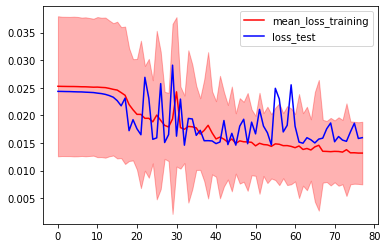

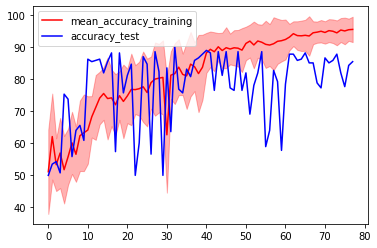

,Loss,Accruacy
Training,0.013172,95.619048
Validation,0.015962,85.546875


In [38]:
np_loss_train_mean = np.array(loss_train_mean)
np_loss_train_std = np.array(loss_train_std)
np_accuracy_train_mean =np.array(accuracy_train_mean)
np_accuracy_train_std = np.array(accuracy_train_std)
np_loss_test= np.array(loss_test)
np_accuracy_test=np.array(accuracy_test)

plt.figure(1)
plt.plot(np_loss_train_mean,label='mean_loss_training',color= 'r')
plt.fill_between(np.arange(len(np_loss_train_mean)),\
                 np_loss_train_mean-np_loss_train_std,\
                 np_loss_train_mean+np_loss_train_std,color='r',alpha=0.3)
plt.plot(np_loss_test,label='loss_test',color = 'b')
plt.legend()

plt.figure(2)
plt.plot(np_accuracy_train_mean,label='mean_accuracy_training', color='r')
plt.fill_between(np.arange(len(np_accuracy_train_mean)),\
                 np_accuracy_train_mean-np_accuracy_train_std,\
                 np_accuracy_train_mean+np_accuracy_train_std,color='r',alpha=0.3)
plt.plot(accuracy_test,label='accuracy_test',color='b')
plt.legend()
plt.show()

data = [[loss_train_mean[-1], accuracy_train_mean[-1]],
        [loss_test[-1], accuracy_test[-1]]]
frame = pd.DataFrame(data, columns = ['Loss','Accruacy'],
                        index = ['Training','Validation'])
frame